# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from catboost import CatBoostRegressor

import timeit
import numpy as np
import matplotlib.pyplot as plt
import warnings
np.warnings = warnings
warnings.filterwarnings('ignore')

%pip install missingno
import missingno as msno

%pip install skimpy
from skimpy import skim, clean_columns

%pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

%pip install category_encoders
import category_encoders as ce

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем датасет
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
# Основная информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Первые 5 строк
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# Приводим названия столбцов к змеиному стилю
df = clean_columns(df)
df.columns

16 column names have been cleaned

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

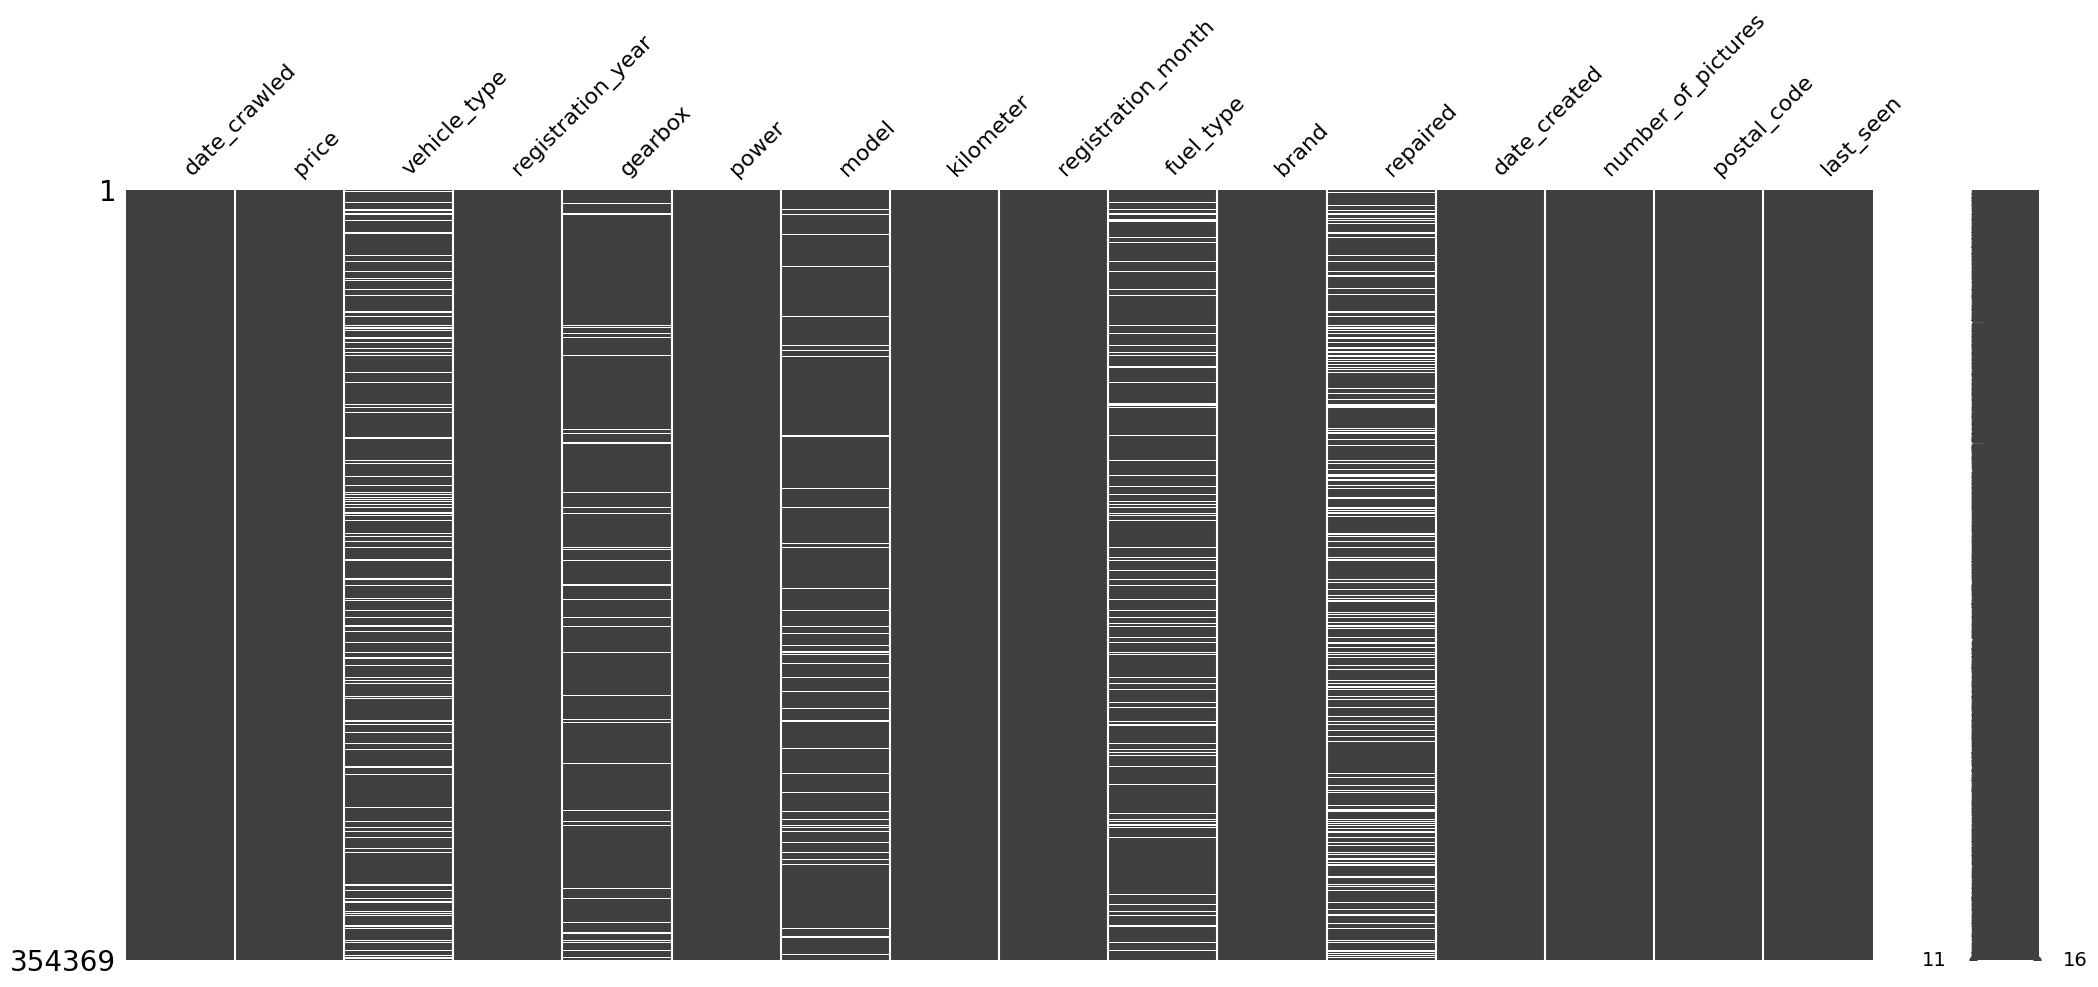

In [6]:
# Визуальное отоборажение пропусков
msno.matrix(df);

По предварительному анализу можно выделить:
1) Пропуски:
    - В столбце `vehicle_type` содержится 11% пропусков
    - В столбце `model` содержится 6% пропусков
    - В столбце `gearbox` содержится 6% пропусков
    - В столбце `fuel_type` содержится 9% пропусков
    - В столбце `repaired` содержится 20% пропусков
2) Аномальные значения:
    - В столбцах `price, power и registration_year` присуствуют аномальные значения, как аномальные низкие, так и аномально высокие
    
3) Неинформативные признаки:
    - `postal_code` — почтовый индекс владельца анкеты (пользователя)
    - `date_crawled` — дата скачивания анкеты из базы
    - `date_created` — дата создания анкеты
    - `last_seen` — дата последней активности пользователя
    - `number_of_pictures` — количество фотографий автомобиля. Этот столбец принимает только одно значение - 0. Он не информативный, поэтому удалим его.
    - `registration_month` — месяц регистрации автомобиля
    
    Информативные признаки:

    - `vehicle_type` — тип автомобильного кузова
    - `registration_year` — год регистрации автомобиля
    - `gearbox` — тип коробки передач
    - `power` — мощность (л. с.)
    - `model` — модель автомобиля
    - `kilometer` — пробег (км)
    - `fuel_type` — тип топлива
    - `brand` — марка автомобиля
    - `repaired` — была машина в ремонте или нет




Удалим неинформативные признаки.

In [7]:
# Удаляем признаки
columns_to_drop = ['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures', 'registration_month']
df.drop(columns_to_drop, axis=1, inplace=True)

### Обработка пропусков

В столбце `vehicle_type` содержится 11% пропусков. Заполним их категорией other.

In [8]:
df['vehicle_type'].fillna('other', inplace=True)

В столбце `model` содержится 6% пропусков. Заполним их other.

In [9]:
df['model'].fillna('other', inplace=True)

В столбце `gearbox` содержится 6% пропусков. Заполним их other.

In [10]:
df['gearbox'].fillna('other', inplace=True)

В столбце `fuel_type` 9% пропусков. Сделаем то же самое.

In [11]:
df['fuel_type'].fillna('other', inplace=True)

В столбце `repaired` содержится 20% пропусков. 87% всех значений это `no`. Вероятнее пользователей не указал, была ли машина в ремонте, так как она не была в ремонте. Запонилним пропуски значениями `no`.

In [12]:
df['repaired'].fillna('no', inplace=True)

### Обработка аномальных значений

Обработаем аномальные значения в столбцах `price` и `power`. Ограничим распределение 5% и 95% квантилями для `price`. 15% и 95% для `power`. Тем самым удалив аномальные значения. 

In [13]:
df.drop(df[(df['price'] < df['price'].quantile(.05)) | (df['price'] > df['price'].quantile(.95))].index, inplace=True)

In [14]:
df.drop(df[(df['power'] < df['power'].quantile(.15)) | (df['power'] > df['power'].quantile(.95))].index, inplace=True)

В `registration_year` присуствуют аномально низкие и аномально высокие значения. Удалим их.

In [15]:
# Удаляем значения ниже 1910 и выше 2019
df.drop((df[(df['registration_year'] < 1910) | (df['registration_year'] >= 2016)]).index, inplace=True)

In [16]:
# Выводим уникальные значения столбца registration_year
df['registration_year'].sort_values().unique()

array([1910, 1937, 1941, 1942, 1943, 1948, 1949, 1950, 1951, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

### Обработка явных дубликатов

Проверим датасет на наличие явных дубликатов.

In [17]:
df.duplicated().sum()

39279

Удалим явные дубликаты.

In [18]:
df.drop_duplicates(inplace=True)

### Подготовка датасета для обучения моделей

Создадим 2 датасета:
1) Первый датасет будет использоваться с моделью линейной регресси. Для этой модели требуется закодировать категориальные признаки. Закодируем их методами OneHotEncoding и TargetEncoding.
2) Второй датасет будет использоваться с CatBoost и LightGBM. Для этих моделей кодирование категориальных признаков не требуется. Достаточно перевести категориальные признаки в формат `category`.

In [19]:
# Датасет для линейной регрессии
df_encoded = df.copy()

# Датасет для моделей catboost и lightGBM
df_boost = df.copy()

In [20]:
# Сохраним значение random_state в отдельную переменную
state = 12345

#### Подготовка датасета для модели линейной регрессии

Разделим датасет на обучающую и тестовую выборку в соотношении 80% обучающая и 20% тестовая.

In [21]:
# Разделим датасет на обучающую и тестовую выборку
train_encoded, test_encoded = train_test_split(df_encoded, test_size=0.2, random_state=state)

In [22]:
print('Размер обучающей выборки:', train_encoded.shape)
print('Размер тестовой выборки:', test_encoded.shape)

Размер обучающей выборки: (165379, 10)
Размер тестовой выборки: (41345, 10)


In [23]:
# Обучающая выборка
train_features_encoded = train_encoded.drop(['price'], axis=1)
train_target_encoded = train_encoded['price']

# Тествая выборка
test_features_encoded = test_encoded.drop(['price'], axis=1)
test_target_encoded = test_encoded['price']

In [24]:
# Определяем список столбцов, которые требуется закодировать
columns_to_encode = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

# Создаем экземпляр OneHotEncoder из библиотеки category_encoders
encoder = ce.OneHotEncoder(cols=columns_to_encode, use_cat_names=True)

# Применяем кодирование One-Hot на обучающем наборе данных
train_features_encoded = encoder.fit_transform(train_features_encoded)

# Применяем кодирование One-Hot на тестовом наборе данных с использованием уже обученного кодировщика
test_features_encoded = encoder.transform(test_features_encoded)

In [25]:
# Удаляем первый признак из каждой категории, что бы избежать мультиколлинерности
columns_to_delete = ['vehicle_type_bus', 'gearbox_auto', 'fuel_type_cng', 'repaired_no']

# Удаляем столбцы из обучающего набора данных
train_features_encoded.drop(columns=columns_to_delete, axis=1, inplace=True)

# Удаляем столбцы из тестового набора данных
test_features_encoded.drop(columns=columns_to_delete, axis=1, inplace=True)

Что бы избежать 'проклятья размерности' воспользуеся Target Encoding для столбцов `model` и `brand`.

In [26]:
# Создаем экземпляр среднего кодирования из библиотеки category_encoders
encoder = ce.TargetEncoder(cols=['model', 'brand'])

# Применяем кодирование целевого значения на столбцах 'model' и 'brand' обучающего набора данных
encoder_train = encoder.fit_transform(train_features_encoded[['model', 'brand']],
                                      pd.DataFrame(train_target_encoded)['price'])

# Применяем кодирование целевого значения на столбцах 'model' и 'brand' тестового набора данных
encoder_test = encoder.transform(test_features_encoded[['model', 'brand']],
                                 pd.DataFrame(test_target_encoded)['price'])

# Удаляем столбцы 'model' и 'brand' из обучающего набора данных
train_features_encoded.drop(['model', 'brand'], axis=1, inplace=True)

# Удаляем столбцы 'model' и 'brand' из тестового набора данных
test_features_encoded.drop(['model', 'brand'], axis=1, inplace=True)

# Объединяем закодированные столбцы с обучающим набором данных
train_features_encoded = train_features_encoded.join(encoder_train)

# Объединяем закодированные столбцы с тестовым набором данных
test_features_encoded = test_features_encoded.join(encoder_test)

Стандартизируем признаки для закодированного датасета.

In [27]:
# Создаем объект StandardScaler
scaler = StandardScaler()

# Определяем список столбцов, которые нужно масштабировать
col_to_scale = ['power', 'kilometer', 'registration_year']

# Обучаем scaler на тренировочных данных
scaler.fit(train_features_encoded[col_to_scale])

# Масштабируем выбранные столбцы в тренировочном наборе данных
train_features_encoded[col_to_scale] = scaler.transform(train_features_encoded[col_to_scale])

# Масштабируем выбранные столбцы в тестовом наборе данных
test_features_encoded[col_to_scale] = scaler.transform(test_features_encoded[col_to_scale])

#### Подготовка датасета для моделей CatBoost и LightGBM

Для моделей CatBoost и LightGBM переведём категориальные признаки тип `category`.

In [28]:
# Столбцы с категориальными признаками
categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand']

# Преобразование выбранных столбцов в тип 'category'
df_boost[categorical_columns] = df_boost[categorical_columns].astype('category')

Разделим датасет на обучающую и тестовую выборку в соотношении 80% обучающая и 20% тестовая.

In [29]:
# Разделим датасет на обучающую и тестовую выборку
train_boost, test_boost = train_test_split(df_boost, test_size=0.2, random_state=state)

In [30]:
print('Размер обучающей выборки:', train_boost.shape)
print('Размер тестовой выборки:', test_boost.shape)

Размер обучающей выборки: (165379, 10)
Размер тестовой выборки: (41345, 10)


Разделяем на `features` и `target`.

In [31]:
# Обучающая выборка
train_features = train_boost.drop(['price'], axis=1)
train_target = train_boost['price']

# Тествая выборка
test_features = test_boost.drop(['price'], axis=1)
test_target = test_boost['price']

### Вывод по подготовке данных
На этапе предподготовки данных, были выполненые такие шаги:
- Изучили датасет
- Заполнили пропуски
- Обработали аномальные значения
- Удалили неинформативные признаки
- Удалили явные дубликаты
- Закодировали категориальные признаки прямым кодированием (One-Hot-Encoding) и Target Encoding
- Разделили датасет на обучающую и тестовую выборку
- Стандартизировали признаки

## Обучение моделей

Определяем метрику оценки производительности RMSE

In [32]:
rmse_score = make_scorer(mean_squared_error, squared=False)

Создадим таблицу, куда будем сохранять результаты, что бы в дальнейшем проанализировать их.

In [33]:
results_df = pd.DataFrame(columns=['model', 'best_rmse', 'rmse_test', 'params_time', 'predict_time'])

In [34]:
results_fit_time = pd.DataFrame(columns=['fit_time'])

Создадим функцию обучения моделей.

In [35]:
def train_model(model, params, train_features, train_target, test_features, results_df, cat_features=None):
    # Создаем объект GridSearchCV с моделью model, сеткой параметров params,
    # кросс-валидацией на 5 фолдах и оценкой по scoring-функции rmse_score
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring=rmse_score)
    
    # Засекаем время начала обучения модели
    start_time = timeit.default_timer()
    
    # Обучаем модель
    if cat_features is None:
        # Если `cat_features` не указаны, то обучаем модель без учета категориальных признаков
        grid.fit(train_features, train_target)
    else:
        # Если `cat_features` указаны, то обучаем модель с учетом категориальных признаков
        grid.fit(train_features, train_target, cat_features=cat_features)
   
    # Засекаем время окончания обучения модели
    end_time = timeit.default_timer()
    
    # Получаем лучший результат и параметры из объекта GridSearchCV
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # Вычисляем время подбора гиперпараметров
    params_time = end_time - start_time
    
    # Засекаем время начала предсказания на тестовых признаках
    start_time_predict = timeit.default_timer()
    
    # Делаем предсказания на тестовых признаках
    predictions = grid.predict(test_features)
    
    # Засекаем время окончания предсказания
    end_time_predict = timeit.default_timer()
    
    # Вычисляем время предсказания
    predict_time = end_time_predict - start_time_predict
    
    # Вычисляем RMSE (среднеквадратичную ошибку) между предсказаниями и целевой переменной тестовых данных
    rmse_test = np.sqrt(mean_squared_error(test_target, predictions))
    
    # Добавляем результаты в таблицу
    results_df.loc[len(results_df)] = [model.__class__.__name__, best_score, rmse_test, params_time, predict_time]

    # Возвращаем лучшие гиперпараметры модели
    return best_params

In [36]:
# Функция вычисляющая время обучения модели
def fit_time_cal(model, train_features, train_target, best_params, results, cat_features=None, random_state=None):
    # Создаем модель с использованием переданных параметров и указанным random_state
    if random_state is None:
        model = model(**best_params)
    else:
        model = model(random_state=state, **best_params)

    # Засекаем время начала обучения модели
    start_time = timeit.default_timer()
    
    if cat_features is None:
        # Если `cat_features` не указаны, то обучаем модель без учета категориальных признаков
        model.fit(train_features, train_target)
    else:
        # Если `cat_features` указаны, то обучаем модель с учетом категориальных признаков
        model.fit(train_features, train_target, cat_features=cat_features)
        
    # Засекаем время окончания обучения модели
    end_time = timeit.default_timer()

    # Вычисляем время обучения
    fit_time = end_time - start_time

    # Сохраняем время обучения в столбец 'fit_time' DataFrame results_df
    results.loc[len(results)] = [fit_time]

### Модель линейной регрессии

In [37]:
# Создаем объект LinearRegression
lin_reg = LinearRegression()

# Определяем параметры для поиска по сетке
lin_params = {'fit_intercept':[True, False]}

# Вызываем функцию train_model для обучения модели с заданными параметрами
lin_best_params = train_model(
    lin_reg, lin_params, train_features_encoded, train_target_encoded, test_features_encoded, results_df
)

In [38]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(LinearRegression, train_features_encoded, train_target_encoded, lin_best_params, results_fit_time)

In [39]:
results_df.loc[results_df['model'] == 'LinearRegression']

,model,best_rmse,rmse_test,params_time,predict_time
0,LinearRegression,2144.455585,2121.437286,1.722778,0.011919


In [40]:
print('Лучшие гиперпараметры для модели линейной регрессии:', lin_best_params)

Лучшие гиперпараметры для модели линейной регрессии: {'fit_intercept': False}


### Модель градиентного бустинга LightGBM

In [41]:
# Создаем модель LGBMRegressor с указанным random_state
lgbm_model = LGBMRegressor(random_state=state)

# Задаем параметры для гиперпараметров модели
lgbm_params = {'max_depth': [1, 2], 'n_estimators': [25, 50]}

# Вызываем функцию train_model для обучения модели с использованием указанных параметров
lgbm_best_params = train_model(lgbm_model, lgbm_params, train_features, train_target, test_features, results_df)

In [42]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(LGBMRegressor, train_features, train_target, lgbm_best_params, results_fit_time, random_state=state)

In [43]:
print('Лучшие гиперпараметры для модели LightGBM:', lgbm_best_params)

Лучшие гиперпараметры для модели LightGBM: {'max_depth': 1, 'n_estimators': 25}


In [44]:
results_df.loc[results_df['model'] == 'LGBMRegressor']

,model,best_rmse,rmse_test,params_time,predict_time
1,LGBMRegressor,2271.449517,2257.78108,4.419502,0.020149


### Модель градиентного бустинга CatBoostRegressor

In [45]:
cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand']

In [46]:
# Создаем модель CatBoostRegressor с указанным random_state
cat_boost_model = CatBoostRegressor(random_state=state)

# Задаем параметры для гиперпараметров модели
cat_boost_params = {'max_depth': [4, 6],
                   'iterations': [50, 100]}

# Вызываем функцию train_model для обучения модели с использованием указанных параметров
cat_boost_best_params = train_model(
    cat_boost_model, 
    cat_boost_params, 
    train_features, 
    train_target, 
    test_features, 
    results_df, 
    cat_features
)

Learning rate set to 0.5
0:	learn: 2568.5613557	total: 215ms	remaining: 10.5s
1:	learn: 2157.6618099	total: 258ms	remaining: 6.19s
2:	learn: 1910.0532432	total: 304ms	remaining: 4.76s
3:	learn: 1792.0797194	total: 349ms	remaining: 4.01s
4:	learn: 1716.1433022	total: 400ms	remaining: 3.6s
5:	learn: 1676.6486767	total: 450ms	remaining: 3.3s
6:	learn: 1636.0364614	total: 497ms	remaining: 3.05s
7:	learn: 1615.5120158	total: 555ms	remaining: 2.91s
8:	learn: 1597.9931486	total: 608ms	remaining: 2.77s
9:	learn: 1578.8048562	total: 650ms	remaining: 2.6s
10:	learn: 1567.1802373	total: 696ms	remaining: 2.46s
11:	learn: 1555.7536334	total: 749ms	remaining: 2.37s
12:	learn: 1539.5495199	total: 807ms	remaining: 2.3s
13:	learn: 1530.0347033	total: 862ms	remaining: 2.22s
14:	learn: 1520.7677297	total: 917ms	remaining: 2.14s
15:	learn: 1509.4521152	total: 966ms	remaining: 2.05s
16:	learn: 1503.3575611	total: 1.01s	remaining: 1.97s
17:	learn: 1498.5172415	total: 1.06s	remaining: 1.89s
18:	learn: 1495.0

5:	learn: 1683.2496116	total: 254ms	remaining: 1.86s
6:	learn: 1637.8967894	total: 297ms	remaining: 1.82s
7:	learn: 1613.0492666	total: 362ms	remaining: 1.9s
8:	learn: 1593.4371072	total: 400ms	remaining: 1.82s
9:	learn: 1578.7617065	total: 438ms	remaining: 1.75s
10:	learn: 1565.7871154	total: 479ms	remaining: 1.7s
11:	learn: 1550.9638274	total: 517ms	remaining: 1.64s
12:	learn: 1542.8873918	total: 555ms	remaining: 1.58s
13:	learn: 1532.8812920	total: 593ms	remaining: 1.52s
14:	learn: 1524.3576627	total: 628ms	remaining: 1.46s
15:	learn: 1508.5748614	total: 665ms	remaining: 1.41s
16:	learn: 1500.0173246	total: 702ms	remaining: 1.36s
17:	learn: 1495.4023867	total: 740ms	remaining: 1.32s
18:	learn: 1490.8953274	total: 783ms	remaining: 1.28s
19:	learn: 1485.6878074	total: 820ms	remaining: 1.23s
20:	learn: 1482.1666198	total: 860ms	remaining: 1.19s
21:	learn: 1478.7804792	total: 897ms	remaining: 1.14s
22:	learn: 1475.5569008	total: 935ms	remaining: 1.1s
23:	learn: 1471.0538311	total: 972ms

9:	learn: 1498.2694671	total: 648ms	remaining: 2.59s
10:	learn: 1487.2957375	total: 729ms	remaining: 2.58s
11:	learn: 1479.4100540	total: 787ms	remaining: 2.49s
12:	learn: 1469.1628450	total: 853ms	remaining: 2.43s
13:	learn: 1461.6001118	total: 913ms	remaining: 2.35s
14:	learn: 1454.7219103	total: 969ms	remaining: 2.26s
15:	learn: 1451.6260232	total: 1.05s	remaining: 2.23s
16:	learn: 1447.3329223	total: 1.11s	remaining: 2.16s
17:	learn: 1441.7638680	total: 1.18s	remaining: 2.09s
18:	learn: 1439.1264212	total: 1.24s	remaining: 2.02s
19:	learn: 1435.4129602	total: 1.3s	remaining: 1.95s
20:	learn: 1429.8635310	total: 1.38s	remaining: 1.91s
21:	learn: 1423.6863094	total: 1.44s	remaining: 1.83s
22:	learn: 1411.5057444	total: 1.49s	remaining: 1.75s
23:	learn: 1407.0228009	total: 1.56s	remaining: 1.69s
24:	learn: 1403.1665902	total: 1.63s	remaining: 1.63s
25:	learn: 1398.3562110	total: 1.69s	remaining: 1.56s
26:	learn: 1393.7034519	total: 1.75s	remaining: 1.49s
27:	learn: 1390.4413076	total:

12:	learn: 1473.7819186	total: 945ms	remaining: 2.69s
13:	learn: 1462.7382856	total: 1.02s	remaining: 2.61s
14:	learn: 1454.6671137	total: 1.08s	remaining: 2.53s
15:	learn: 1448.8481618	total: 1.16s	remaining: 2.47s
16:	learn: 1444.9751142	total: 1.23s	remaining: 2.38s
17:	learn: 1442.1436419	total: 1.29s	remaining: 2.29s
18:	learn: 1436.4056913	total: 1.35s	remaining: 2.21s
19:	learn: 1430.1392844	total: 1.42s	remaining: 2.13s
20:	learn: 1424.2213691	total: 1.49s	remaining: 2.05s
21:	learn: 1419.5206458	total: 1.56s	remaining: 1.99s
22:	learn: 1416.9285168	total: 1.66s	remaining: 1.95s
23:	learn: 1413.4646121	total: 1.77s	remaining: 1.91s
24:	learn: 1408.5321784	total: 1.85s	remaining: 1.85s
25:	learn: 1406.2786842	total: 1.93s	remaining: 1.78s
26:	learn: 1403.0872499	total: 2s	remaining: 1.7s
27:	learn: 1399.0732405	total: 2.07s	remaining: 1.62s
28:	learn: 1393.9904593	total: 2.14s	remaining: 1.55s
29:	learn: 1390.9791420	total: 2.23s	remaining: 1.48s
30:	learn: 1386.7727757	total: 2

15:	learn: 1525.2346760	total: 702ms	remaining: 3.68s
16:	learn: 1514.5524484	total: 743ms	remaining: 3.63s
17:	learn: 1508.4497163	total: 785ms	remaining: 3.58s
18:	learn: 1498.5580420	total: 822ms	remaining: 3.5s
19:	learn: 1493.9424771	total: 861ms	remaining: 3.44s
20:	learn: 1491.1365787	total: 898ms	remaining: 3.38s
21:	learn: 1487.1082182	total: 937ms	remaining: 3.32s
22:	learn: 1481.5792618	total: 975ms	remaining: 3.26s
23:	learn: 1475.2309854	total: 1.01s	remaining: 3.21s
24:	learn: 1465.4492591	total: 1.05s	remaining: 3.16s
25:	learn: 1462.2253116	total: 1.09s	remaining: 3.12s
26:	learn: 1458.8996777	total: 1.14s	remaining: 3.07s
27:	learn: 1455.5909805	total: 1.18s	remaining: 3.04s
28:	learn: 1451.8481488	total: 1.23s	remaining: 3.02s
29:	learn: 1448.8741049	total: 1.29s	remaining: 3.01s
30:	learn: 1445.4638908	total: 1.33s	remaining: 2.96s
31:	learn: 1442.4429614	total: 1.38s	remaining: 2.92s
32:	learn: 1440.6494589	total: 1.42s	remaining: 2.88s
33:	learn: 1438.2763814	total

69:	learn: 1382.7881718	total: 2.94s	remaining: 1.26s
70:	learn: 1381.7582592	total: 2.98s	remaining: 1.22s
71:	learn: 1381.3861655	total: 3.02s	remaining: 1.18s
72:	learn: 1379.2915340	total: 3.06s	remaining: 1.13s
73:	learn: 1378.4467913	total: 3.1s	remaining: 1.09s
74:	learn: 1377.1062383	total: 3.14s	remaining: 1.05s
75:	learn: 1376.1957140	total: 3.19s	remaining: 1s
76:	learn: 1375.2165747	total: 3.23s	remaining: 963ms
77:	learn: 1374.5978691	total: 3.29s	remaining: 927ms
78:	learn: 1374.4239646	total: 3.33s	remaining: 886ms
79:	learn: 1373.2584118	total: 3.38s	remaining: 844ms
80:	learn: 1372.8632140	total: 3.44s	remaining: 808ms
81:	learn: 1372.6045268	total: 3.5s	remaining: 769ms
82:	learn: 1371.4534621	total: 3.54s	remaining: 725ms
83:	learn: 1370.6709840	total: 3.58s	remaining: 682ms
84:	learn: 1369.9786318	total: 3.63s	remaining: 640ms
85:	learn: 1369.9613718	total: 3.67s	remaining: 597ms
86:	learn: 1369.2363502	total: 3.7s	remaining: 553ms
87:	learn: 1368.8876506	total: 3.7

21:	learn: 1481.0366774	total: 876ms	remaining: 3.1s
22:	learn: 1476.7863779	total: 919ms	remaining: 3.08s
23:	learn: 1474.8713414	total: 961ms	remaining: 3.04s
24:	learn: 1470.3333794	total: 1.01s	remaining: 3.02s
25:	learn: 1466.6540806	total: 1.05s	remaining: 3s
26:	learn: 1461.4515735	total: 1.1s	remaining: 2.97s
27:	learn: 1459.8749311	total: 1.14s	remaining: 2.94s
28:	learn: 1455.1118015	total: 1.23s	remaining: 3.01s
29:	learn: 1451.9834167	total: 1.27s	remaining: 2.97s
30:	learn: 1449.3086296	total: 1.32s	remaining: 2.94s
31:	learn: 1445.9778471	total: 1.36s	remaining: 2.9s
32:	learn: 1442.9807704	total: 1.41s	remaining: 2.86s
33:	learn: 1438.5939324	total: 1.45s	remaining: 2.82s
34:	learn: 1435.4796832	total: 1.49s	remaining: 2.77s
35:	learn: 1433.8412834	total: 1.53s	remaining: 2.73s
36:	learn: 1432.2456353	total: 1.57s	remaining: 2.67s
37:	learn: 1429.9482012	total: 1.61s	remaining: 2.63s
38:	learn: 1427.6380503	total: 1.65s	remaining: 2.58s
39:	learn: 1424.3261512	total: 1.6

76:	learn: 1308.0999523	total: 5.5s	remaining: 1.64s
77:	learn: 1307.2960513	total: 5.57s	remaining: 1.57s
78:	learn: 1307.2252804	total: 5.64s	remaining: 1.5s
79:	learn: 1305.4268527	total: 5.71s	remaining: 1.43s
80:	learn: 1304.8720275	total: 5.76s	remaining: 1.35s
81:	learn: 1304.4539163	total: 5.82s	remaining: 1.28s
82:	learn: 1303.7220387	total: 5.89s	remaining: 1.21s
83:	learn: 1302.7152540	total: 5.96s	remaining: 1.14s
84:	learn: 1302.6353268	total: 6.02s	remaining: 1.06s
85:	learn: 1301.5809747	total: 6.09s	remaining: 991ms
86:	learn: 1300.7197734	total: 6.15s	remaining: 919ms
87:	learn: 1299.8653055	total: 6.23s	remaining: 849ms
88:	learn: 1298.4625630	total: 6.3s	remaining: 778ms
89:	learn: 1297.4776837	total: 6.36s	remaining: 707ms
90:	learn: 1296.9155575	total: 6.42s	remaining: 635ms
91:	learn: 1296.1498520	total: 6.5s	remaining: 565ms
92:	learn: 1294.9705343	total: 6.57s	remaining: 494ms
93:	learn: 1294.2674957	total: 6.64s	remaining: 424ms
94:	learn: 1292.7536030	total: 6

30:	learn: 1383.2128613	total: 2.02s	remaining: 4.5s
31:	learn: 1379.3870656	total: 2.08s	remaining: 4.41s
32:	learn: 1375.4193179	total: 2.14s	remaining: 4.35s
33:	learn: 1373.2243810	total: 2.2s	remaining: 4.27s
34:	learn: 1371.5031448	total: 2.26s	remaining: 4.21s
35:	learn: 1369.5057352	total: 2.32s	remaining: 4.13s
36:	learn: 1368.7003824	total: 2.39s	remaining: 4.07s
37:	learn: 1366.1994351	total: 2.46s	remaining: 4.01s
38:	learn: 1364.2286172	total: 2.53s	remaining: 3.95s
39:	learn: 1361.7456985	total: 2.59s	remaining: 3.88s
40:	learn: 1360.5607497	total: 2.65s	remaining: 3.82s
41:	learn: 1358.0124552	total: 2.71s	remaining: 3.75s
42:	learn: 1356.8336887	total: 2.82s	remaining: 3.73s
43:	learn: 1355.5915259	total: 2.88s	remaining: 3.66s
44:	learn: 1355.2581579	total: 2.94s	remaining: 3.6s
45:	learn: 1353.0222173	total: 3.06s	remaining: 3.6s
46:	learn: 1350.9709527	total: 3.13s	remaining: 3.53s
47:	learn: 1349.6702171	total: 3.2s	remaining: 3.46s
48:	learn: 1348.2114168	total: 3.

83:	learn: 1302.9722267	total: 5.94s	remaining: 1.13s
84:	learn: 1302.5059046	total: 6s	remaining: 1.06s
85:	learn: 1301.1875965	total: 6.06s	remaining: 986ms
86:	learn: 1300.4504937	total: 6.12s	remaining: 915ms
87:	learn: 1300.1433621	total: 6.18s	remaining: 843ms
88:	learn: 1299.6289644	total: 6.26s	remaining: 773ms
89:	learn: 1298.3983418	total: 6.35s	remaining: 706ms
90:	learn: 1297.8018762	total: 6.41s	remaining: 634ms
91:	learn: 1297.1508622	total: 6.48s	remaining: 563ms
92:	learn: 1296.8017656	total: 6.55s	remaining: 493ms
93:	learn: 1296.2625193	total: 6.61s	remaining: 422ms
94:	learn: 1295.6506677	total: 6.68s	remaining: 351ms
95:	learn: 1295.2639196	total: 6.74s	remaining: 281ms
96:	learn: 1293.5347921	total: 6.81s	remaining: 211ms
97:	learn: 1292.4298359	total: 6.87s	remaining: 140ms
98:	learn: 1291.6045956	total: 6.93s	remaining: 70ms
99:	learn: 1290.7690824	total: 7.04s	remaining: 0us
Learning rate set to 0.5
0:	learn: 2481.7486807	total: 54.6ms	remaining: 5.4s
1:	learn: 

38:	learn: 1424.7988255	total: 1.79s	remaining: 504ms
39:	learn: 1422.3216934	total: 1.83s	remaining: 457ms
40:	learn: 1419.6035210	total: 1.87s	remaining: 411ms
41:	learn: 1417.3690981	total: 1.91s	remaining: 364ms
42:	learn: 1415.5678265	total: 1.95s	remaining: 318ms
43:	learn: 1414.6580449	total: 2s	remaining: 272ms
44:	learn: 1412.9869947	total: 2.04s	remaining: 227ms
45:	learn: 1411.7869911	total: 2.08s	remaining: 181ms
46:	learn: 1409.7891464	total: 2.13s	remaining: 136ms
47:	learn: 1409.3956036	total: 2.17s	remaining: 90.4ms
48:	learn: 1408.1951470	total: 2.21s	remaining: 45.1ms
49:	learn: 1406.5908997	total: 2.28s	remaining: 0us


In [47]:
# Вызываем функцию fit_time_cal для вычисления времени обучения модели
fit_time_cal(
    CatBoostRegressor, train_features, train_target, cat_boost_best_params, results_fit_time, cat_features, random_state=state
)

Learning rate set to 0.5
0:	learn: 2568.1158279	total: 45.5ms	remaining: 2.23s
1:	learn: 2169.1368832	total: 88.2ms	remaining: 2.12s
2:	learn: 1964.1294186	total: 134ms	remaining: 2.1s
3:	learn: 1826.9770615	total: 189ms	remaining: 2.17s
4:	learn: 1737.8753237	total: 253ms	remaining: 2.27s
5:	learn: 1690.6833370	total: 305ms	remaining: 2.23s
6:	learn: 1637.1325660	total: 353ms	remaining: 2.17s
7:	learn: 1618.7186535	total: 395ms	remaining: 2.07s
8:	learn: 1600.6528778	total: 438ms	remaining: 2s
9:	learn: 1584.1587016	total: 491ms	remaining: 1.96s
10:	learn: 1562.5623050	total: 533ms	remaining: 1.89s
11:	learn: 1552.4730776	total: 572ms	remaining: 1.81s
12:	learn: 1541.3511774	total: 610ms	remaining: 1.74s
13:	learn: 1532.7138775	total: 650ms	remaining: 1.67s
14:	learn: 1524.9357907	total: 688ms	remaining: 1.61s
15:	learn: 1517.0412513	total: 740ms	remaining: 1.57s
16:	learn: 1510.5136585	total: 784ms	remaining: 1.52s
17:	learn: 1502.7547683	total: 825ms	remaining: 1.47s
18:	learn: 1498

In [48]:
print('Лучшие гиперпараметры для модели CatBoost:', cat_boost_best_params)

Лучшие гиперпараметры для модели CatBoost: {'iterations': 50, 'max_depth': 4}


In [49]:
results_df.loc[results_df['model'] == 'CatBoostRegressor']

,model,best_rmse,rmse_test,params_time,predict_time
2,CatBoostRegressor,1408.771347,1398.001925,92.300107,0.031426


### Вывод по обучению моделей
На этапе обучения моделей, обучили 3 модели:
- LinearRegression - Модель линейной регрессии
- LGBMRegressor - Модель градиентного бустинга LightGBM
- CatBoostRegressor	- Модель градиентного бустинга CatBoostRegressor

Результаты сохранили в таблицу `results_df`. Проанализируем и выберем лучшую модель на этапе анализа моделей.

## Анализ моделей

В этом разделе проанализируем собранные данные в таблице `results_df`.

In [50]:
# Объеденим результаты
results_df = results_df.join(results_fit_time)

In [51]:
# Создадим столбец с сумарным временем обучения и предсказания
results_df['fit_predict_time'] = results_df['fit_time'] + results_df['predict_time']

In [52]:
results_df

,model,best_rmse,rmse_test,params_time,predict_time,fit_time,fit_predict_time
0,LinearRegression,2144.455585,2121.437286,1.722778,0.011919,0.194768,0.206687
1,LGBMRegressor,2271.449517,2257.781080,4.419502,0.020149,0.206642,0.226791
2,CatBoostRegressor,1408.771347,1398.001925,92.300107,0.031426,2.581989,2.613414


In [53]:
# Функция для постороения столбчатой диаграммы
def plot_bar_chart(height, bars, title):
    # Создание массива позиций для каждого столбца на оси x
    x_pos = np.arange(len(bars))
    
    # Определение цветов для столбцов
    colors = ['blue', 'green', 'red', 'orange']
    
    # Создание нового графика с указанным размером
    plt.figure(figsize=(10, 6))
    
    # Построение столбчатой диаграммы
    plt.bar(x_pos, height, color=colors)
    
    # Установка подписей на оси x
    plt.xticks(x_pos, bars)
    
    # Включение сетки по оси y с прозрачностью 0.2
    plt.grid(True, axis='y', alpha=0.2)
    
    # Установка заголовка диаграммы
    plt.title(title)
    plt.ylabel('RMSE')
    
    # Отображение графика
    plt.show()

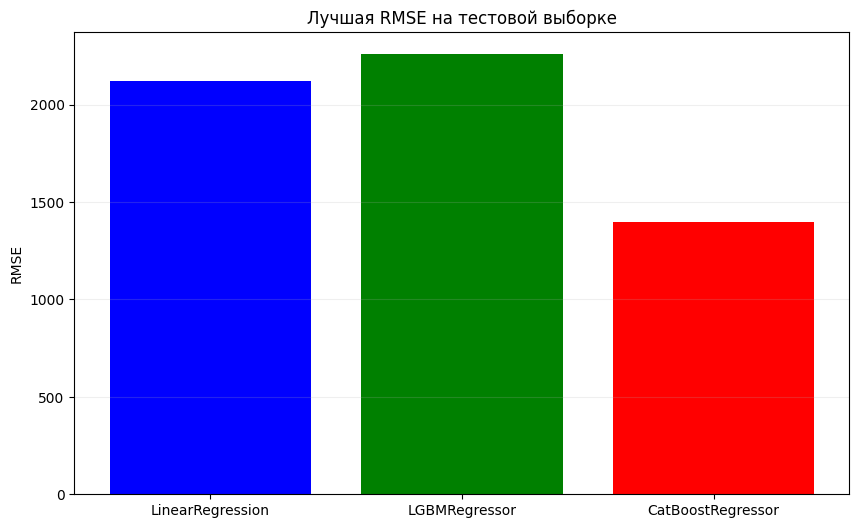

In [54]:
plot_bar_chart(results_df['rmse_test'], results_df['model'], 'Лучшая RMSE на тестовой выборке')

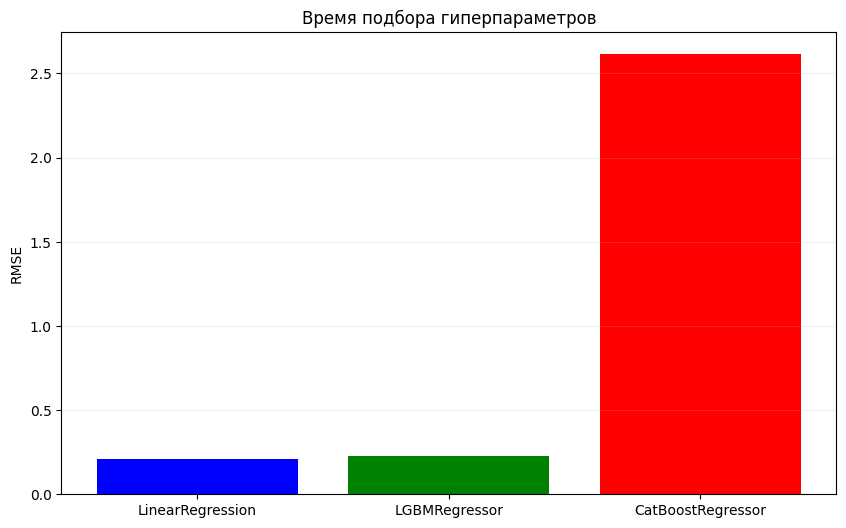

In [55]:
plot_bar_chart(results_df['fit_predict_time'], results_df['model'], 'Время подбора гиперпараметров')

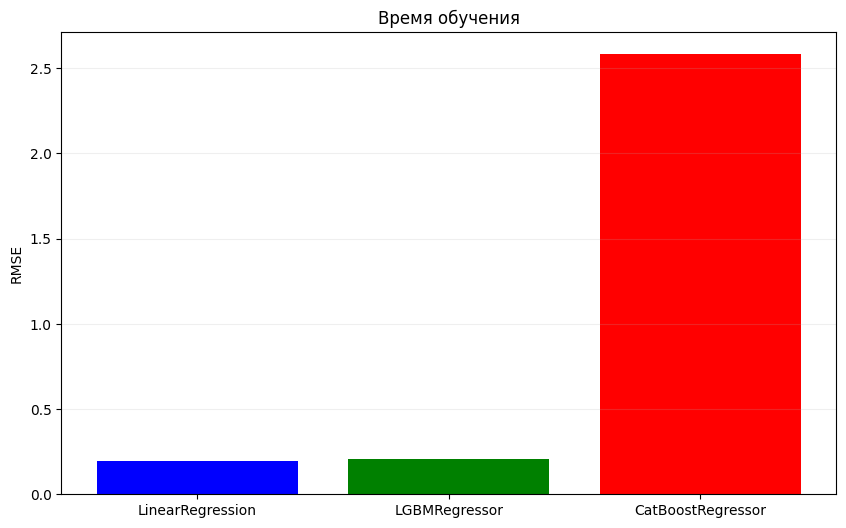

In [56]:
plot_bar_chart(results_df['fit_time'], results_df['model'], 'Время обучения')

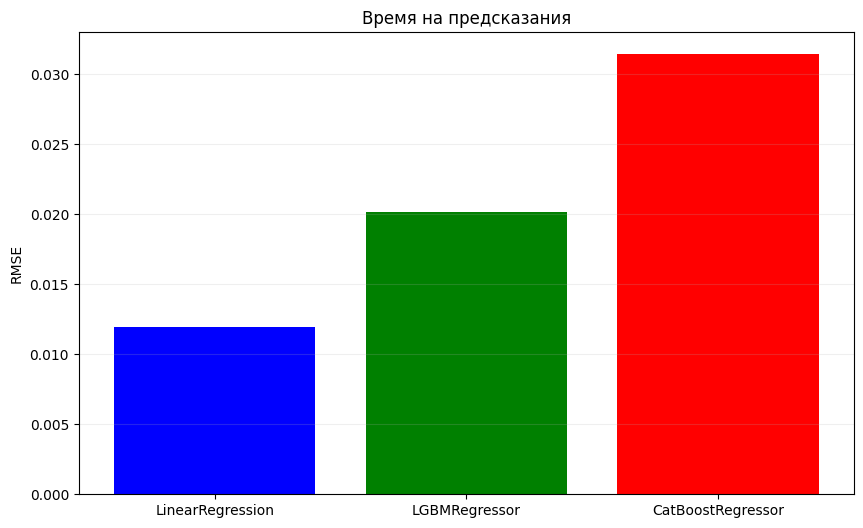

In [57]:
plot_bar_chart(results_df['predict_time'], results_df['model'], 'Время на предсказания')

### Вывод по анализу моделей

Получили такие результаты:

- Лучшее качество предсказаний у модели CatBoost
- Наибольшая скорость предсказаний у модели LinearRegression
- Наименьшее время обучения у модели LinearRegression

## Вывод по проекту

В этом проекте нам нужно было построить модель для определения рыночной стоимости автомобиля. 

В этом проекте мы сделали:
- Изучили датасет
- Заполнили пропуски
- Обработали аномальные значения
- Удалили неинформативные признаки
- Удалили явные дубликаты
- Закодировали категориальные признаки прямым кодированием (One-Hot-Encoding) и Target Encoding
- Разделили датасет на обучающую и тестовую выборку
- Стандартизировали признаки
- Обучили 3 модели:
    - LinearRegression - Модель линейной регрессии
    - LGBMRegressor - Модель градиентного бустинга LightGBM
    - CatBoostRegressor - Модель градиентного бустинга CatBoostRegressor
- Собрали результаты в таблице `results_df`
- Проанализировали модели
- Выбрали лучшую модель подходящию заказчику по 3 параметрам: по качеству предсказаний, скорость предсказаний и времени обучения.

По итогу лучшее значение RMSE у модели CatBoost, по остальным параметрам она уступает таким моделям, как LinearRegression и LightBoost.